In [69]:
import os
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from fuzzywuzzy import fuzz

# Getting Data

In [70]:
dataset_path = os.path.join(os.environ['PWD'],'movielens_dataset')
movies_filename = 'movies.csv'
ratings_filename = 'ratings.csv'

In [71]:
df_movies = pd.read_csv(os.path.join(dataset_path, movies_filename), usecols=['movieId','title','genres'], dtype={'movieId': 'int32', 'title': 'str','genres':'str'})
df_ratings = pd.read_csv(os.path.join(dataset_path, ratings_filename), usecols=['userId','movieId','rating'], dtype={'userId':'int32','movieId':'int32','rating':'float32'})

In [72]:
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [73]:
df_ratings.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


# Inferences from Data

In [74]:
num_users = len(df_ratings.userId.unique())
num_movies = len(df_movies.movieId.unique())
print("Number of users: " ,num_users)
print("Number of movies: " ,num_movies)

Number of users:  610
Number of movies:  9742


In [75]:
# Number of ratings per movie
df_movies_cnt = pd.DataFrame(df_ratings.groupby('movieId').size(), columns=['count'])
df_movies_cnt.head()

,count
movieId,
1,215
2,110
3,52
4,7
5,49


[]

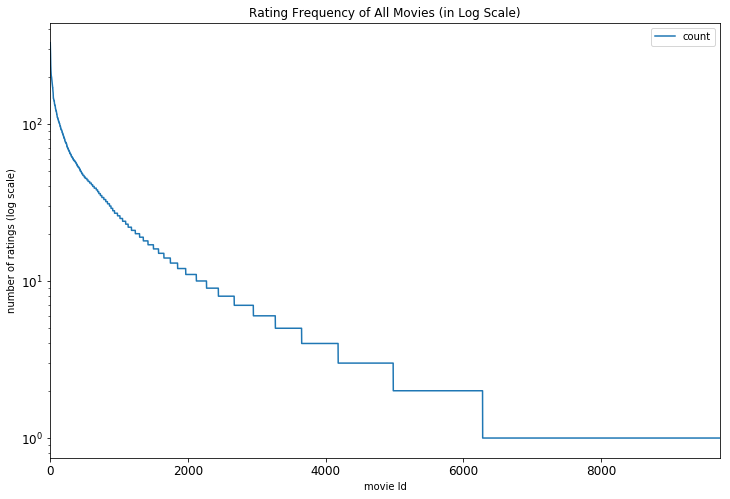

In [76]:
ax = df_movies_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Movies (in Log Scale)',
        fontsize=12,
        logy=True
    )
ax.set_xlabel("movie Id")
ax.set_ylabel("number of ratings (log scale)")
ax.plot()

In [77]:
# filter data to include only movies with 10 or more ratings (popular movies)
popularity_thres = 10
popular_movies = list(set(df_movies_cnt.query('count >= @popularity_thres').index))
df_ratings_drop_movies = df_ratings[df_ratings.movieId.isin(popular_movies)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping unpopular movies: ', df_ratings_drop_movies.shape)
print('Number of unique movies: ', num_movies)
print('Number of unique movies after dropping: ', len(df_ratings_drop_movies.movieId.unique()))

shape of original ratings data:  (100836, 3)
shape of ratings data after dropping unpopular movies:  (81116, 3)
Number of unique movies:  9742
Number of unique movies after dropping:  2269


In [78]:
#Number of ratings given by every user
df_users_cnt = pd.DataFrame(df_ratings_drop_movies.groupby('userId').size(), columns=['count'])
df_users_cnt.head()

,count
userId,
1,211
2,26
3,24
4,179
5,44


[]

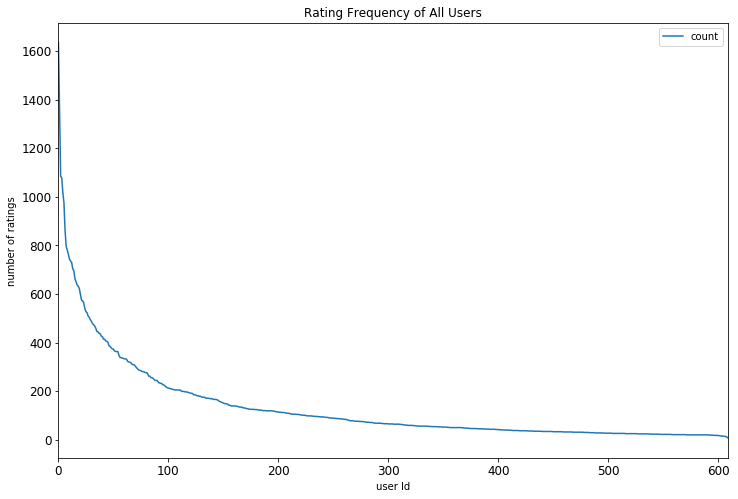

In [79]:
# plot rating frequency of all movies
ax = df_users_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Users',
        fontsize=12
    )
ax.set_xlabel("user Id")
ax.set_ylabel("number of ratings")
ax.plot()

In [80]:
# filter data to include only users with 100 or more ratings (active users)
ratings_thres = 100
active_users = list(set(df_users_cnt.query('count >= @ratings_thres').index))
df_ratings_drop_users = df_ratings_drop_movies[df_ratings_drop_movies.userId.isin(active_users)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping both unpopular movies and inactive users: ', df_ratings_drop_users.shape)
print('Total number of unique users: ', num_users)
print('Number of unique users after dropping inactive users: ', len(df_ratings_drop_users.userId.unique()))

shape of original ratings data:  (100836, 3)
shape of ratings data after dropping both unpopular movies and inactive users:  (63927, 3)
Total number of unique users:  610
Number of unique users after dropping inactive users:  225


In [81]:
print('Total number of unique movies after filtering data: ', len(df_ratings_drop_users.movieId.unique()))
print('Total number of unique users after filtering data: ', len(df_ratings_drop_users.userId.unique()))

Total number of unique movies after filtering data:  2269
Total number of unique users after filtering data:  225


# Train KNN Model

In [82]:
#Reshape the Data
#Movies as rows and Users as Columns, Cell entry is rating
movie_user_matrix = df_ratings_drop_users.pivot(index='movieId', columns='userId', values='rating').fillna(0)
movie_user_matrix.head()

userId,1,4,6,7,10,15,17,18,19,20,...,597,599,600,602,603,605,606,607,608,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,4.5,0.0,2.5,4.5,3.5,4.0,0.0,...,4.0,3.0,2.5,0.0,4.0,4.0,2.5,4.0,2.5,5.0
2,0.0,0.0,4.0,0.0,0.0,0.0,0.0,3.0,3.0,3.0,...,0.0,2.5,4.0,4.0,0.0,3.5,0.0,0.0,2.0,0.0
3,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,...,0.0,1.5,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
5,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,4.0,0.0,4.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,3.0,4.5,0.0,3.0,4.0,0.0,0.0,0.0,0.0,5.0


In [83]:
#Mapper from movie title to index
movie_to_index = {
    movie:i for i,movie in 
    enumerate(list(df_movies.set_index('movieId').loc[movie_user_matrix.index].title))
}

In [84]:
#transform to scipy sparse matrix
movie_user_matrix_sparse = csr_matrix(movie_user_matrix.values)

In [85]:
# define model
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
model_knn.fit(movie_user_matrix_sparse)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
         metric_params=None, n_jobs=-1, n_neighbors=20, p=2, radius=1.0)

# Use Trained Model

In [105]:
def fuzzy_matching(mapper, fav_movie, verbose=True):
    match_tuple = []
    for title, idx in mapper.items():
        ratio = fuzz.ratio(title.lower(), fav_movie.lower())
        if ratio >= 60:
            match_tuple.append((title, idx, ratio))
    match_tuple = sorted(match_tuple, key=lambda x: x[2])[::-1]
    if not match_tuple:
        print('Oops! No match is found')
        return -20
    print('Found possible matches in our database: {0}\n'.format([x[0] for x in match_tuple]))
    return match_tuple[0][1]

def make_recommendation(model_knn, data, mapper, fav_movie, n_recommendations):
    model_knn.fit(data)
    print('You have input movie:', fav_movie)
    idx = fuzzy_matching(mapper, fav_movie)
    if(idx != -20):
        print('Recommendation system start to make inference')
        print('\n')
        distances, indices = model_knn.kneighbors(data[idx], n_neighbors=n_recommendations+1)
        raw_recommends = sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())), key=lambda x: x[1])[:0:-1]
        reverse_mapper = {v: k for k, v in mapper.items()}
        print('Recommendations for {}:'.format(fav_movie))
        for i, (idx, dist) in enumerate(raw_recommends):
            print('{0}: {1}, with distance of {2}'.format(i+1, reverse_mapper[idx], dist))

        
        

In [106]:
my_favorite = 'Iron Man'

make_recommendation(
    model_knn=model_knn,
    data=movie_user_matrix_sparse,
    fav_movie=my_favorite,
    mapper=movie_to_index,
    n_recommendations=5)

You have input movie: Iron Man
Found possible matches in our database: ['Iron Man (2008)', 'Iron Man 3 (2013)', 'Iron Man 2 (2010)']

Recommendation system start to make inference


Recommendations for Iron Man:
1: Avengers, The (2012), with distance of 0.28469324111938477
2: Iron Man 2 (2010), with distance of 0.2821824550628662
3: WALL·E (2008), with distance of 0.250507116317749
4: Avatar (2009), with distance of 0.23695969581604004
5: Dark Knight, The (2008), with distance of 0.21203958988189697


In [107]:
my_favorite =  'Captain America'

make_recommendation(
    model_knn=model_knn,
    data=movie_user_matrix_sparse,
    fav_movie=my_favorite,
    mapper=movie_to_index,
    n_recommendations=5)

You have input movie: Captain America
Found possible matches in our database: ['Captain America: Civil War (2016)']

Recommendation system start to make inference


Recommendations for Captain America:
1: Avengers: Infinity War - Part I (2018), with distance of 0.3013914227485657
2: Captain America: The Winter Soldier (2014), with distance of 0.2956676483154297
3: Ant-Man (2015), with distance of 0.2824859619140625
4: Logan (2017), with distance of 0.2519223690032959
5: X-Men: Apocalypse (2016), with distance of 0.22565019130706787


In [108]:
my_favorite =  'Cinderella'

make_recommendation(
    model_knn=model_knn,
    data=movie_user_matrix_sparse,
    fav_movie=my_favorite,
    mapper=movie_to_index,
    n_recommendations=5)

You have input movie: Cinderella
Found possible matches in our database: ['Cinderella (1950)', 'Cinderella Man (2005)']

Recommendation system start to make inference


Recommendations for Cinderella:
1: Beauty and the Beast (1991), with distance of 0.42615580558776855
2: Little Mermaid, The (1989), with distance of 0.41103285551071167
3: Pinocchio (1940), with distance of 0.40324294567108154
4: Snow White and the Seven Dwarfs (1937), with distance of 0.339469313621521
5: Peter Pan (1953), with distance of 0.3324127793312073


In [109]:
my_favorite =  'Harry Potter and the Goblet of Fire'

make_recommendation(
    model_knn=model_knn,
    data=movie_user_matrix_sparse,
    fav_movie=my_favorite,
    mapper=movie_to_index,
    n_recommendations=5)

You have input movie: Harry Potter and the Goblet of Fire
Found possible matches in our database: ['Harry Potter and the Goblet of Fire (2005)', 'Harry Potter and the Chamber of Secrets (2002)', 'Harry Potter and the Half-Blood Prince (2009)', 'Harry Potter and the Order of the Phoenix (2007)', 'Harry Potter and the Prisoner of Azkaban (2004)', 'Harry Potter and the Deathly Hallows: Part 2 (2011)', 'Harry Potter and the Deathly Hallows: Part 1 (2010)']

Recommendation system start to make inference


Recommendations for Harry Potter and the Goblet of Fire:
1: Pirates of the Caribbean: Dead Man's Chest (2006), with distance of 0.29144203662872314
2: Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001), with distance of 0.24587154388427734
3: Harry Potter and the Order of the Phoenix (2007), with distance of 0.22954535484313965
4: Harry Potter and the Chamber of Secrets (2002), with distance of 0.22097939252853394
5: Harry Potter and the Prisoner